In [219]:
# %pip show pip
# %pip install -U scikit-learn

In [5]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
from utils import standardize
from datetime import datetime
from models.losses import *
from ts2vec import TS2Vec
from pathlib import Path
from tqdm import tqdm
from os import walk
import pandas as pd
import numpy as np
import datautils
import torch
import json





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# TODO: Challenges to solve with stock data
    # Have to deal with weekends - time series not continuous (maybe include time features like hour and daily)
    # Habe to deal with hours between stock opened and stock closed

In [2]:
mypath      = "/Users/abuj/Documents/GitHub/CFT/datasets/STOCKS/hour/"
ffd_path    = "/Users/abuj/Documents/GitHub/CFT/datasets/META_FEATURES/FFD/hour/"
cpd_path    = "/Users/abuj/Documents/GitHub/CFT/datasets/META_FEATURES/CPD/hour/"

filenames   = next(walk(mypath), (None, None, []))[2]  

cols_to_perform_ffd = ['open', 'high', 'low', 'close', 'vwap']


In [125]:

data_dict = {}

LOOKBACK_WINDOW                 = 7      # Hyper parameter
STANDARIZE_LOOKBACK_WINDOW      = 7 * 3  # Hyper parameter

for file in tqdm(filenames[330:]):
    df                  = pd.read_csv(mypath + file).set_index('timestamp')[cols_to_perform_ffd]
    df_ffd              = pd.read_csv(ffd_path + file).set_index('timestamp')

    df                  = standardize(df,     look_back=STANDARIZE_LOOKBACK_WINDOW)
    df_ffd              = standardize(df_ffd, look_back=STANDARIZE_LOOKBACK_WINDOW)

    idx                 = df_ffd.index.intersection(df.index)
    df, df_ffd          = df.loc[idx], df_ffd.loc[idx]


    X_data_array        = []
    EXP_FEAT_data_array = []

    for i in range(LOOKBACK_WINDOW, len(df)+1):
        X_data_array.append( df.iloc[i - LOOKBACK_WINDOW:i].values )
        EXP_FEAT_data_array.append( df_ffd.iloc[i-1].values ) # Without minus one, the exp features lead X_DATA by one tiemstamp
        assert df_ffd.iloc[i-1].name  == df.iloc[i - LOOKBACK_WINDOW:i].iloc[-1].name 

    X_data_array        = np.array( X_data_array )
    EXP_FEAT_data_array = np.array( EXP_FEAT_data_array )

    data_dict[file[:-4]]                  = {}
    data_dict[file[:-4]]['X_DATA']        = X_data_array
    data_dict[file[:-4]]['EXP_FEAT_DATA'] = EXP_FEAT_data_array
    # data_dict[file[:-4]]['Y_DATA']        = EXP_FEAT_data_array #TODO: generate labels
    # print(file, X_data_array.shape, EXP_FEAT_data_array.shape)


100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


In [167]:
pct_train          = 0.8
train_data         = np.concatenate( [data_dict[x]['X_DATA'][:int(pct_train*len(data_dict[x]['X_DATA']))] for x in data_dict.keys()])
exp_train_data     = np.concatenate( [data_dict[x]['EXP_FEAT_DATA'][:int(pct_train*len(data_dict[x]['X_DATA']))] for x in data_dict.keys()])
# train_labels       = np.concatenate( [data_dict[x]['Y_DATA'][:int(pct_train*len(data_dict[x]['X_DATA']))] for x in data_dict.keys()])
assert train_data.shape[0] == exp_train_data.shape[0] 
print(train_data.shape, exp_train_data.shape)


test_data         = np.concatenate( [data_dict[x]['X_DATA'][int(pct_train*len(data_dict[x]['X_DATA'])):] for x in data_dict.keys()])
exp_test_data     = np.concatenate( [data_dict[x]['EXP_FEAT_DATA'][int(pct_train*len(data_dict[x]['X_DATA'])):] for x in data_dict.keys()])
# test_labels       = np.concatenate( [data_dict[x]['Y_DATA'][:int(pct_train*len(data_dict[x]['X_DATA']))] for x in data_dict.keys()])
assert test_data.shape[0] == exp_test_data.shape[0] 
print(test_data.shape, exp_test_data.shape)
# # (Both train_data and test_data have a shape of n_instances x n_timestamps x n_features)


(108030, 20, 5) (108030, 10)
(27012, 20, 5) (27012, 10)


In [168]:



# Train a TS2Vec model
model = TS2Vec(
    input_dims=train_data.shape[-1],
    device=0,
    output_dims=320
)
loss_log = model.fit(
    train_data,
    expert_features=exp_train_data, # train_data.reshape(100, -1)[:,40:],
    verbose=True
)

# Compute timestamp-level representations for test set
test_repr_tl = model.encode(test_data)  # n_instances x n_timestamps x output_dims

# Compute instance-level representations for test set
test_repr_il = model.encode(test_data, encoding_window='full_series')  # n_instances x output_dims

# Sliding inference for test set
test_repr_si = model.encode(
    test_data,
    casual=True,
    sliding_length=1,
    sliding_padding=50
)  # n_instances x n_timestamps x output_dims
# (The timestamp t's representation vector is computed using the observations located in [t-50, t])

KeyboardInterrupt: 

In [170]:


# # Load the ECG200 dataset from UCR archive
train_data, train_labels, test_data, test_labels = datautils.load_ECG()
# # (Both train_data and test_data have a shape of n_instances x n_timestamps x n_features)

exp_feat = pd.DataFrame(  train_data.reshape(100, -1)[:,40:] )
exp_feat = pd.DataFrame(  exp_feat.mean(axis=1) ).values


# Train a TS2Vec model
model = TS2Vec(
    input_dims=1,
    device=0,
    output_dims=320
)
loss_log = model.fit(
    train_data,
    expert_features=exp_feat, #train_data.reshape(100, -1)[:,40:],
    verbose=True
)

# Compute timestamp-level representations for test set
test_repr_tl = model.encode(test_data)  # n_instances x n_timestamps x output_dims

# Compute instance-level representations for test set
test_repr_il = model.encode(test_data, encoding_window='full_series')  # n_instances x output_dims

# Sliding inference for test set
test_repr_si = model.encode(
    test_data,
    casual=True,
    sliding_length=1,
    sliding_padding=50
)  # n_instances x n_timestamps x output_dims
# (The timestamp t's representation vector is computed using the observations located in [t-50, t])

Epoch #0: loss=4.902282357215881
Epoch #1: loss=3.4583623011906943
Epoch #2: loss=3.439666191736857
Epoch #3: loss=3.2492870489756265


KeyboardInterrupt: 

<AxesSubplot:>

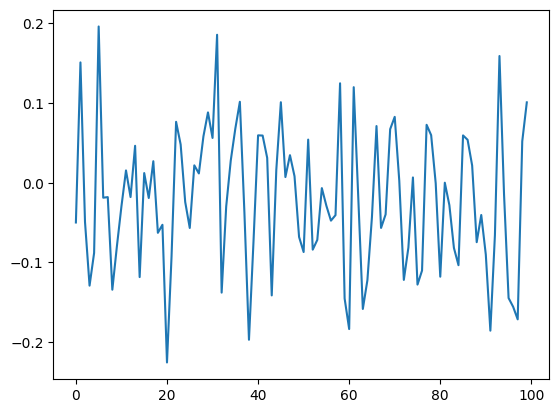

In [73]:
pd.DataFrame(test_repr_il)[4].plot()

In [7]:
batch_xi     = torch.randn(32, 50)
batch_xj     = torch.randn(32, 50)
batch_f      = torch.randn(32, 10)


In [18]:

quadratic_contrastive_loss(batch_xi, batch_f, delta=1)

tensor(0.2878)

In [11]:
max_diff = get_max_norm(batch_f)


similarity_measure(batch_f[0], batch_f[1], max_diff)

tensor(0.0563)

In [71]:
expclr_loss(batch_xi, batch_f, delta=2)


tensor(0.1493)

In [63]:
from tensorflow.keras.layers import LSTM
import tensorflow as tf

inputs = tf.random.normal([5, 3, 10])
lstm = tf.keras.layers.LSTM(20)
output = lstm(inputs)
print(output.shape)


(5, 20)


In [90]:
rnn = nn.LSTM(10, 20, batch_first=True)
input = torch.randn(5, 3, 10)
# h0 = torch.randn(2, 3, 20)
# c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input)

In [184]:
hn.reshape(hn.shape[1:]).shape

torch.Size([5, 20])

In [91]:
print( output.shape )
print( hn.shape )
print( cn.shape )

torch.Size([5, 3, 20])
torch.Size([1, 5, 20])
torch.Size([1, 5, 20])


In [189]:
hn.squeeze(0)

torch.Size([5, 20])

In [181]:
output[:,-1:,:].reshape(5, 20).shape

torch.Size([5, 20])

In [120]:
output[:,-1:,:].reshape(5, 20) == hn.reshape(5, 20)

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True]])

In [7]:
# data, train_slice, valid_slice, test_slice, scaler, pred_lens, n_covariate_cols = datautils.load_forecast_csv("ETTh2")
# train_data = data[:, train_slice]
        
# # Train a TS2Vec model
# model = TS2Vec(
#     input_dims=1,
#     device=0,
#     output_dims=320
# )
# loss_log = model.fit(
#     train_data,
#     verbose=True
# )

# # Compute timestamp-level representations for test set
# test_repr = model.encode(test_data)  # n_instances x n_timestamps x output_dims

# # Compute instance-level representations for test set
# test_repr = model.encode(test_data, encoding_window='full_series')  # n_instances x output_dims

# # Sliding inference for test set
# test_repr = model.encode(
#     test_data,
#     casual=True,
#     sliding_length=1,
#     sliding_padding=50
# )  # n_instances x n_timestamps x output_dims
# # (The timestamp t's representation vector is computed using the observations located in [t-50, t])